In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import seaborn as sns
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation, models,util

ImportError: cannot import name '_imaging' from 'PIL' (/usr/lib/python3/dist-packages/PIL/__init__.py)

## Compute euclidean distance of the chosen sentences as gold standard

In [2]:
def compute_gold_standard(model):
    sentence1 = model.encode("How does Obvion determine the comparative interest?")
    sentence2 = model.encode("Obvion determines the comparative interest per loan component.")  
    distance_gold = np.linalg.norm(np.array(sentence1) - np.array(sentence2))
    return distance_gold

## Compute distance matrix

In [3]:
def compute_distance_matrix(data, cluster_size, distance_gold):
    distance_matrix = list()
    for i in range(cluster_size):
        cluster = data[data["cluster"]==i]
        cluster = cluster.drop(["Unnamed: 0", "cluster", "article"],axis=1)
        tensors = []
        for i in range(cluster.shape[0]):
            tensor = [tensor for tensor in cluster.iloc[i,:]]
            tensors.append(tensor)
        length = len(tensors)
        dimension = len(tensors[0])
        distances = np.zeros([length, length])
        for i in range(length):
            for j in range(length):
                t1 = np.array(tensors[i])
                t2 = np.array(tensors[j])
                distances[i][j] = np.linalg.norm(np.array(tensors[i]) - np.array(tensors[j]))/distance_gold
        distance_matrix.append(distances)
    return {dimension:distance_matrix}

## Compute maximum and average distance across all clusters

In [4]:
def compute_max_var_avg_distance(distance_matrix):
    max_distance = list()
    avg_distance = list()
    var_distance = list()
    for d in distance_matrix:
        max_distance.append(np.amax(d))
        avg_distance.append(np.average(d))
        var_distance.append(np.var(d))
    return max_distance,var_distance,avg_distance

## Plot max distances and average distances

In [32]:
def plot_distances(max_distances, var_distances, avg_distances,keys, cluster):
    plt.figure(figsize=(15,7))
    plt.title(f"Maximum Scaled Distances for {cluster} clusters")
    for i in range(len(max_distances)):
        plt.plot(max_distances[i], label=keys[i])
    plt.xlabel("Cluster")
    plt.ylabel("Scaled Distance")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.axhline(1)
    plt.show()
    
    plt.figure(figsize=(15,7))
    plt.title(f"Average Scaled Distances for {cluster} cluster")
    for i in range(len(avg_distances)):
        plt.plot(avg_distances[i], label=keys[i])
    plt.xlabel("Cluster")
    plt.ylabel("Scaled Distance")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.axhline(1)
    plt.show()
    
    plt.figure(figsize=(15,7))
    plt.title(f"Scaled Distance Variance for {cluster} cluster")
    for i in range(len(var_distances)):
        plt.plot(var_distances[i], label=keys[i])
    plt.xlabel("Cluster")
    plt.ylabel("Distance Variance")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()

## Process data and make plots

In [27]:
cluster_list = [10,25,50]
distance_wrapper = list()
directory = "data_for_distance_matrix"
for cluster_size in cluster_list:
    distance_list=list()
    folder_path = directory+"/cluster_"+str(cluster_size)+"/"
    for file_path in os.listdir(folder_path):
        data = pd.read_csv(folder_path+file_path)
        dim = len(data.drop(["Unnamed: 0", "cluster", "article"],axis=1).iloc[0])
        model = SentenceTransformer("./text_to_be_trained/fine_tuned_model_"+str(dim))
        distance_gold = compute_gold_standard(model)
        distance_dict = compute_distance_matrix(data, cluster_size,distance_gold)
        distance_list.append(distance_dict)
    distance_wrapper.append({cluster_size:distance_list})

In [28]:
max_distances = []
var_distances = []
avg_distances = []
keys = []
for c in range(len(distance_wrapper)):
    distance_wapper_child = distance_wrapper[c]
    cluster_size = list(distance_wapper_child.keys())[0]
    for d in range(len(distance_wapper_child[cluster_size])):
        distance_dict = distance_wapper_child[cluster_size][d]
        for k in distance_dict.keys():
            keys.append(k)
            distance_matrix = distance_dict[k]
            max_d,var_d,avg_d = compute_max_var_avg_distance(distance_matrix)
            max_distances.append(max_d)
            var_distances.append(var_d)
            avg_distances.append(avg_d)
keys = list(set(keys))

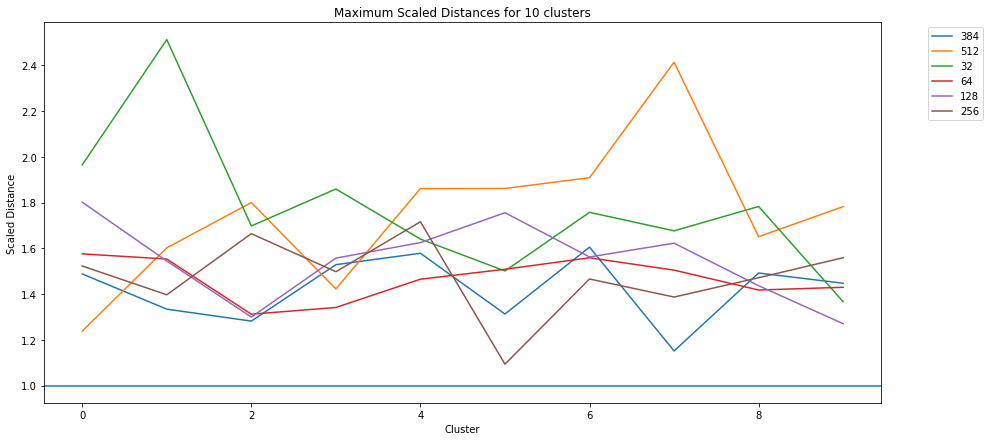

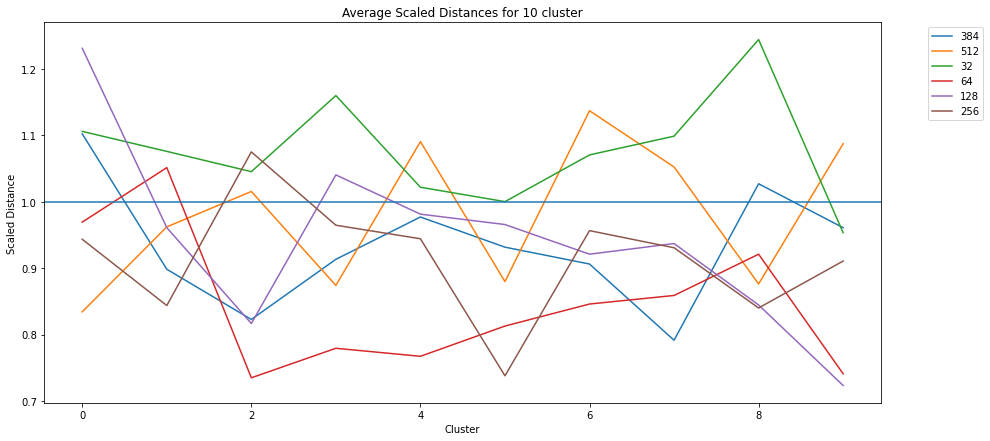

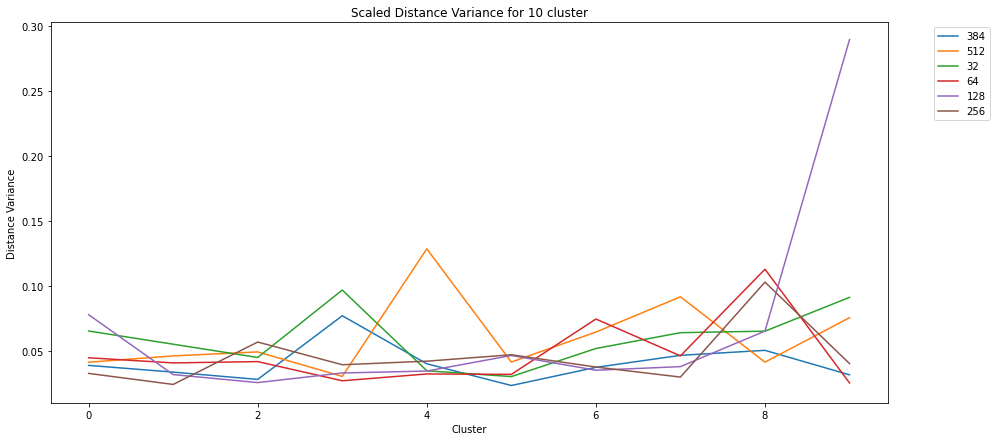

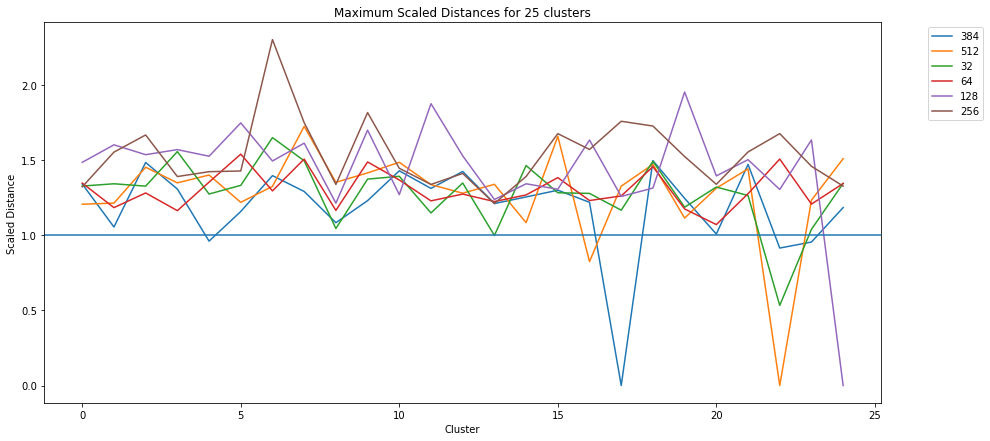

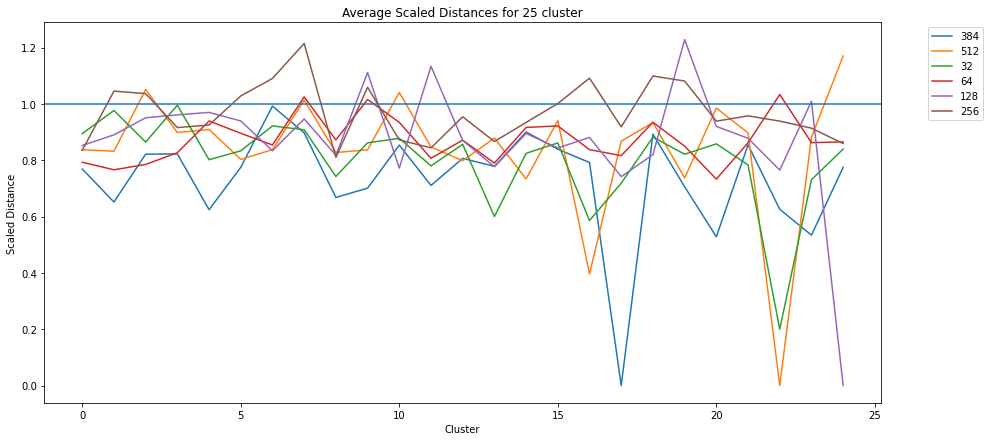

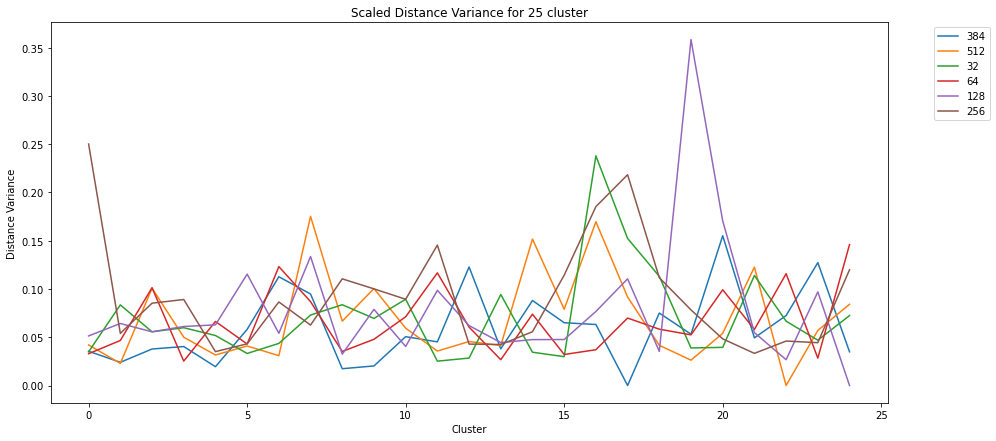

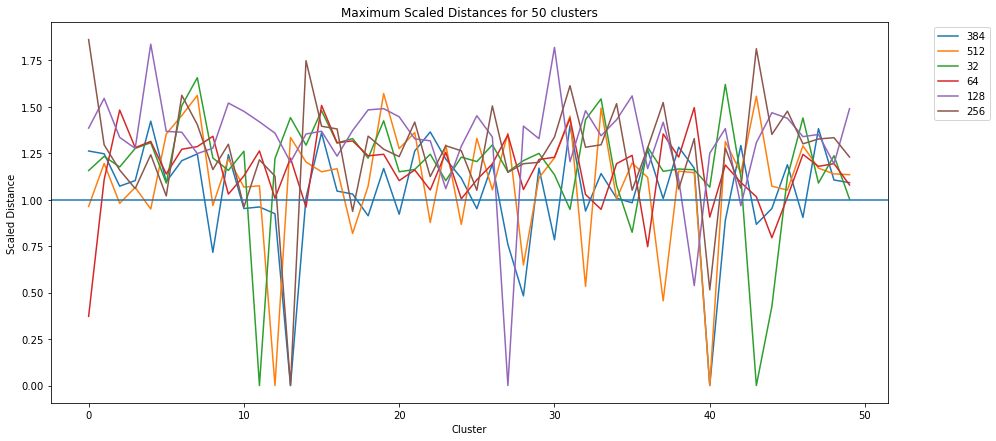

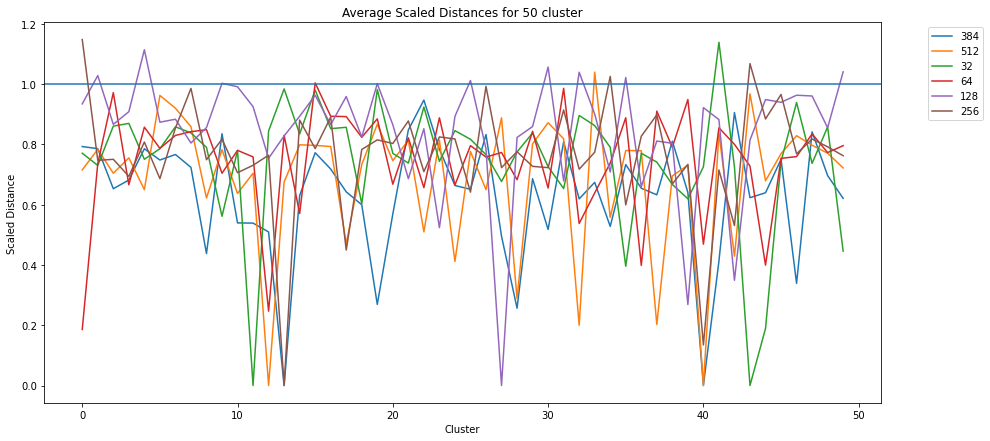

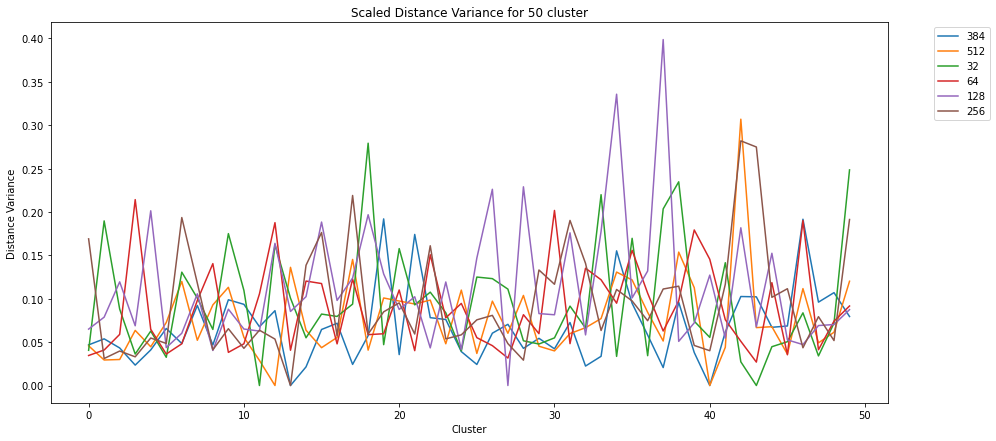

In [33]:
start = 0
end = len(keys)
len_keys = len(keys)
for cluster_size in cluster_list:
    plot_distances(max_distances[start:end], var_distances[start:end], avg_distances[start:end],keys, cluster_size)
    start = start+len_keys
    end = end+len_keys